In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy  as np
from mpl_toolkits.mplot3d import Axes3D

import struct

# Create a NEMA-like phantom
Note we will sample to a 1 mm resolution.  The phantom consists of:

- 4 radioactive spheres of radii 4, 6.5, 8.5, and 11 mm
- 2 cold spheres of radii 14, 18.5 mm
- a cold central cylinder of radius 20 mm and z-length of 100 mm
- all spheres placed at a radial distance of 114.4 mm from the center of the volume, centered axially
- "radioactive" elements have 4 times the activity of "cold" elements 

### Function definitions

In [2]:
def create_sphere(radius):
    """Create a spherical volume of specified radius"""

    s = np.rint(radius*2).astype('int')
    if(s % 2 == 0): s += 1
    
    vol = np.zeros([s,s,s])
    for ii in range(s**3):
        
        nnx = int(ii / s**2)
        nny = int(ii/s) % s
        nnz = int(ii) % s
    
        x = s*(1.0*(nnx+0.5)/s - 0.5)
        y = s*(1.0*(nny+0.5)/s - 0.5)
        z = s*(1.0*(nnz+0.5)/s - 0.5)
        #print("Index",ii,"x=",x,"y=",y,"z=",z)
        
        if(x**2 + y**2 + z**2 <= radius**2):
            vol[nnx,nny,nnz] += 1
    
    return vol

def create_cylinder(radius,halfheight):
    """Create a cylindrical volume of specified radius and height"""
    
    s = np.rint(radius*2).astype('int')
    if(s % 2 == 0): s += 1
    h = np.rint(halfheight*2).astype('int')
    if(h % 2 == 0): h += 1

    vol = np.zeros([s,s,h])
    for ii in range(s**2*h):
        
        nnx = int(ii / (s*h))
        nny = int(ii/h) % s
        nnz = int(ii) % h
    
        x = s*(1.0*(nnx+0.5)/s - 0.5)
        y = s*(1.0*(nny+0.5)/s - 0.5)
        z = h*(1.0*(nnz+0.5)/h - 0.5)
        
        if(x**2 + y**2 <= radius**2 and z > -halfheight and z < halfheight):
            vol[nnx,nny,nnz] += 1
    
    return vol

def add_to_vol(vol,vol_add,x_offset,y_offset,z_offset):
    """Adds vol_add to vol at the specified offset"""
    
    half_x = vol_add.shape[0] - 1
    if(half_x % 2 != 0):
        print("ERROR: half_x = {} not divisible by 2".format(half_x))
        return None
    half_x = int(half_x/2)
    
    half_y = vol_add.shape[1] - 1
    if(half_y % 2 != 0):
        print("ERROR: half_y = {} not divisible by 2".format(half_y))
        return None
    half_y = int(half_y/2)
    
    half_z = vol_add.shape[2] - 1
    if(half_z % 2 != 0):
        print("ERROR: half_z = {} not divisible by 2".format(half_z))
        return None
    half_z = int(half_z/2)
    
    x0 = int((vol.shape[0]-1)/2) + x_offset
    y0 = int((vol.shape[1]-1)/2) + y_offset
    z0 = int((vol.shape[2]-1)/2) + z_offset
    
    vol[x0-half_x:x0+half_x+1,y0-half_y:y0+half_y+1,z0-half_z:z0+half_z+1] += vol_add 

### Construct the phantom in a 3D numpy array

In [3]:
# Create the main volume.
s_vol = 271  # cubic volume side length
vol = np.zeros([s_vol,s_vol,s_vol])

# Create the different components of the phantom.
sph_r1 = create_sphere(4)*4
sph_r2 = create_sphere(6.5)*4
sph_r3 = create_sphere(8.5)*4
sph_r4 = create_sphere(11)*4

sph_c1 = create_sphere(14)
sph_c2 = create_sphere(18.5)

cyl = create_cylinder(20,20)

# Position them in the main volume.
r_pos = 114.4

xoff = np.rint(r_pos).astype('int'); yoff = 0
add_to_vol(vol,sph_r1,xoff,yoff,0)
xoff = np.rint(np.cos(np.pi/3)*r_pos).astype('int'); yoff = np.rint(np.sin(np.pi/3)*r_pos).astype('int')
add_to_vol(vol,sph_r2,xoff,yoff,0)
xoff = np.rint(np.cos(2*np.pi/3)*r_pos).astype('int'); yoff = np.rint(np.sin(2*np.pi/3)*r_pos).astype('int')
add_to_vol(vol,sph_r3,xoff,yoff,0)
xoff = np.rint(np.cos(np.pi)*r_pos).astype('int'); yoff = np.rint(np.sin(np.pi)*r_pos).astype('int')
add_to_vol(vol,sph_r4,xoff,yoff,0)
xoff = np.rint(np.cos(4*np.pi/3)*r_pos).astype('int'); yoff = np.rint(np.sin(4*np.pi/3)*r_pos).astype('int')
add_to_vol(vol,sph_c1,xoff,yoff,0)
xoff = np.rint(np.cos(5*np.pi/3)*r_pos).astype('int'); yoff = np.rint(np.sin(5*np.pi/3)*r_pos).astype('int')
add_to_vol(vol,sph_c1,xoff,yoff,0)

add_to_vol(vol,cyl,0,0,0)

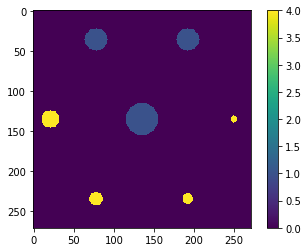

In [4]:
plt.imshow(vol[:,:,135].transpose())
plt.colorbar()

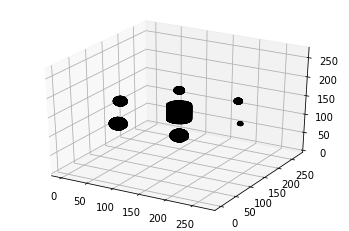

In [5]:
# Note, this plot takes a long time to run
fig = plt.figure()
ax = fig.gca(projection='3d')
vox = ax.voxels(vol, edgecolor='k', cmap='jet')

### Write the distribution to a binary file

In [6]:
# Normalize the volume.
npimg = vol
npimg = npimg.astype('float64') / np.sum(npimg)

In [7]:
# Flatten and convert to a cumulative distribution.
npimg_flat = npimg.flatten().cumsum()

# Pack the header information (Nx, Ny, Nz, Lx, Ly, Lz)
Nx = npimg.shape[0]
Ny = npimg.shape[1]
Nz = npimg.shape[2]
Lx = float(Nx)
Ly = float(Ny)
Lz = float(Nz)
print("Shape = ({},{},{}); size = ({},{},{})".format(Nx,Ny,Nz,Lx,Ly,Lz))

s_hdr1 = struct.pack('i'*3,Nx,Ny,Nz)
s_hdr2 = struct.pack('f'*3,Lx,Ly,Lz)
s_arr = struct.pack('f'*len(npimg_flat), *npimg_flat)
f = open('phantom_NEMAlike.dat','wb')
f.write(s_hdr1)
f.write(s_hdr2)
f.write(s_arr)
f.close()

Shape = (271,271,271); size = (271.0,271.0,271.0)


In [8]:
# Perform some checks.
f2 = open('phantom_NEMAlike.dat','rb')
x1 = f2.read(4)
print(struct.unpack('i',x1))

x2 = f2.read(4)
print(struct.unpack('i',x2))

x3 = f2.read(4)
print(struct.unpack('i',x3))

f2.read(4)
f2.read(4)
f2.read(4)

for ii in range(2097151): f2.read(4)
    
print(struct.unpack('f',f2.read(4)))

f2.close()

(271,)
(271,)
(271,)
(0.18834836781024933,)
